In [1]:
from utils import load_config
import yaml
import os
os.chdir('../../../Interpretable-Deep-Fake-Detection/training/')
import torch
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.set_device(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
sys.argv = ["train.py"]
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from datetime import timedelta
from detectors import DETECTOR
# from trainer.trainer import Trainer
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
import numpy as np

2025-03-31 14:08:11.190830: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 14:08:11.230375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 14:08:11.230408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 14:08:11.230432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 14:08:11.238738: I tensorflow/core/platform/cpu_feature_g

In [2]:
path = "./config/detector/resnet34_bcos_v2_minimal.yaml"
base_path = '/pfs/work7/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/weights/'
pretrained_paths = [f'{base_path}resnet34_v2_minimal/03_10_16_34_15_ckpt_best.pth',
                   f'{base_path}bcos_resnet_minimal_b2_ckpt_best.pth',
                   f'{base_path}resnet34_03_18_16_59_57_ckpt_best.pth']
additional_args_0 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[0],
                  'backbone_config':{'b': 1.25}
                  }
config_0 = load_config(path, additional_args=additional_args_0)
additional_args_1 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[1],
                  'backbone_config':{'b': 2}
                  }
config_1 = load_config(path, additional_args=additional_args_1)
path = "./config/detector/resnet34.yaml"
additional_args_2 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[2],
                   'compression': 'c40'
                  }
config_2 = load_config(path, additional_args=additional_args_2)
configs = [config_0, config_1, config_2]

/pfs/work7/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FaceForensics++


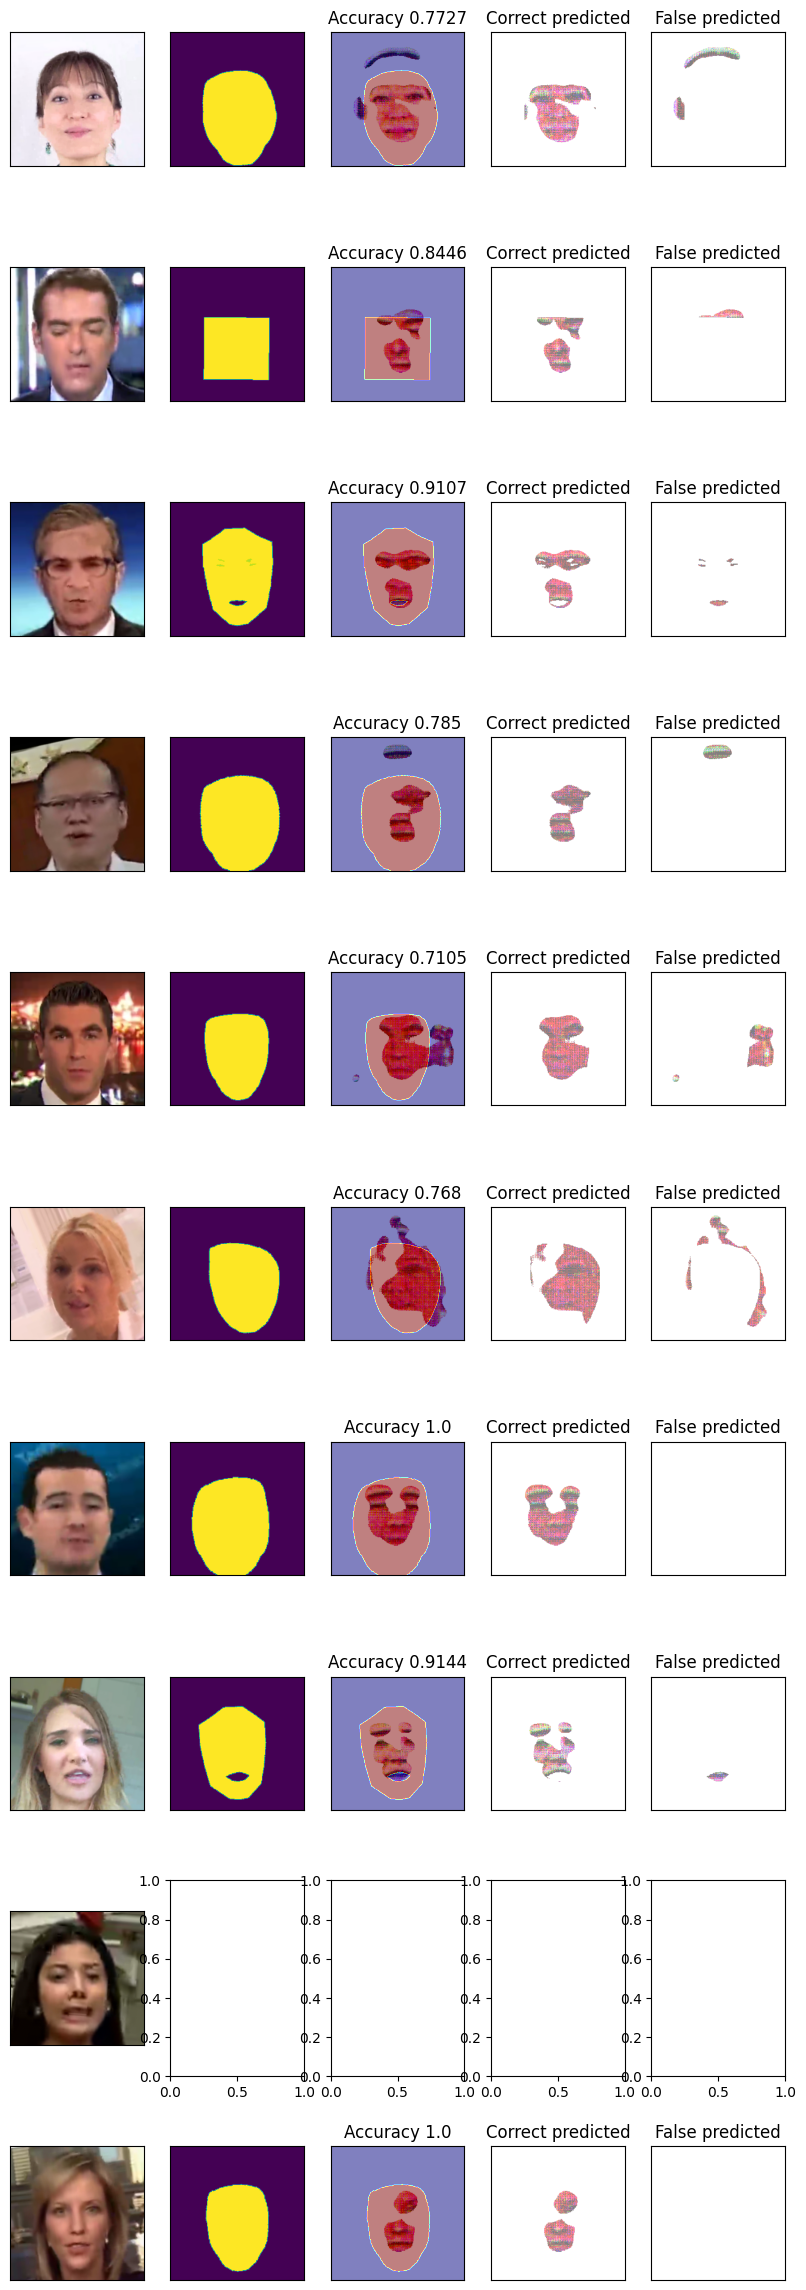

In [43]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from bcos.interpretability import grad_to_img, to_numpy
def mask_game(mask, heatmap):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().numpy()  # Convert tensor to numpy array
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()  # Convert tensor to numpy array
    heatmap = heatmap[:, :, -1:].copy()
    # Ensure both are in the 0-1 range (binary)
    if np.max(heatmap) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("heatmap range may be wrong")
        heatmap = np.where(heatmap > 0, 1, 0)

    if np.max(mask) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("mask range may be wrong")
        mask = np.where(mask > 0, 1, 0)
        
    # assuming mask is a tensor or numpy array
    correct_pixels = np.sum((heatmap == 1) & (mask == 1))  # Pixels that are both predicted as "1" and ground truth "1"
    # print(np.array((heatmap == 1) & (mask == 1)).shape)
    total_predicted_pixels = np.sum(heatmap == 1)  # Total ground truth pixels that are part of the mask
    # print(np.array(heatmap == 1).shape)
    # Step 5: Compute the performance metric (e.g., accuracy)
    accuracy = correct_pixels / total_predicted_pixels if total_predicted_pixels > 0 else 0  # Accuracy based on mask region
    
    # Optionally, calculate Intersection over Union (IoU) for better performance measurement
    intersection = correct_pixels
    union = np.sum((heatmap == 1) | (mask == 1))  # Union of predicted mask and ground truth mask
    iou = intersection / union if union > 0 else 0  # IoU
    
    # Print performance results
    # print(f"Correct Pixels: {correct_pixels}")
    # print(f"Total Mask Pixels: {total_predicted_pixels}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Intersection over Union (IoU): {iou:.4f}")
    return accuracy.round(4)

config = config_1
config['ddp'] = False
config['with_mask'] = True
test_data_loaders = prepare_testing_data(config)
num_plots = 10
threshold = 0.5
device = 'cpu'
fig, axes = plt.subplots(num_plots, 5, figsize=(10, num_plots*3))
for key in ['FaceForensics++']:#test_data_loaders.keys():
         # Prepare the model (detector)
        model_class = DETECTOR[config['model_name']]
        model = model_class(config)
        state_dict = torch.load(config['pretrained'])
        
        # Remove "module." prefix if present in the state_dict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_key = k.replace("module.", "")  # Remove "module." prefix
            new_state_dict[new_key] = v
        model.load_state_dict(new_state_dict)
        model.to(device)
        for i, data_dict in enumerate(test_data_loaders[key]):
            if i< num_plots:
                
                # Process data and ensure labels are binary (0 or 1)
                img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')
                data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

                for key in data_dict.keys():
                    if data_dict[key] is not None:
                        data_dict[key] = data_dict[key].to(device)

                # Take the first image and process it
                img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
                label = label_batch[0]
                mask = mask[0].to('cpu')

                # Generate explanation (replace with your actual explanation function)
                model.backbone.eval()
                explanation = model.backbone.explain(img)

                # Apply threshold to the explanation heatmap to binarize it
                explanation_map = explanation['explanation'][:, :, :].copy()
                explanation_map[:, :, -1] = (explanation_map[:, :, -1] > threshold).astype(np.uint8)  # Convert to 0 or 1 based on threshold


                
                
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)
                row_idx = i 
                # Plot the original image on the left subplot
                axes[row_idx, 0].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                # axes[row_idx, 0].set_title(f"Label {label}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, 0].set_xticks([])
                axes[row_idx, 0].set_yticks([])
                if mask.max()>0.1:
                    # print(mask.shape)
                    # print(mask.max())
                    mask_np = np.array(mask*255)#to_numpy(mask[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)
    
                    # Plot the original image on the left subplot
                    axes[row_idx, 1].imshow(mask_np, extent=(0, config['resolution'], 0, config['resolution']))
                    # axes[row_idx, 1].set_title(f"Label {label}")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, 1].set_xticks([])
                    axes[row_idx, 1].set_yticks([])

                    axes[row_idx, 2].imshow(explanation_map, extent=(0, config['resolution'], 0, config['resolution']))
                    axes[row_idx, 2].imshow(mask_np, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
                    accuracy = mask_game(mask, explanation_map)
                    axes[row_idx, 2].set_title(f"Accuracy {accuracy}")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, 2].set_xticks([])
                    axes[row_idx, 2].set_yticks([])

                    mask = mask.cpu().numpy()
                    correct = np.array((explanation_map == 1) & (mask == 1))
                    # correct = np.array((explanation_map == 1))
                    correct = correct*255
                    axes[row_idx, 3].imshow(correct, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
                    axes[row_idx, 3].set_title("Correct predicted")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, 3].set_xticks([])
                    axes[row_idx, 3].set_yticks([])
                    
                    wrong = np.array((explanation_map == 1) & (mask != 1))
                    # correct = np.array((explanation_map == 1))
                    wrong = wrong*255
                    axes[row_idx, 4].imshow(wrong, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
                    axes[row_idx, 4].set_title("False predicted")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, 4].set_xticks([])
                    axes[row_idx, 4].set_yticks([])
            else:
                break